In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.impute import KNNImputer

# 设置 Matplotlib/Seaborn 的显示风格
sns.set(style="whitegrid")

df = pd.read_csv("data/train.csv")

In [3]:
# 查看每列的缺失值数量
missing_values = df.isnull().sum()
print("各特征的缺失值数量：\n", missing_values[missing_values > 0])

各特征的缺失值数量：
 LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [15]:
# 假设我们只对数值型特征进行KNN填充
numeric_cols = df.select_dtypes(include=np.number).columns
imputer = KNNImputer(n_neighbors=5) # n_neighbors 可以调整

# 注意：KNNImputer 返回的是 numpy array，需要转换回 DataFrame
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# 检查是否还有缺失值
print("填充后，数值型特征的缺失值数量：\n", df[numeric_cols].isnull().sum().sum())

print(df[0:0])


填充后，数值型特征的缺失值数量：
 0
Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

[0 rows

In [20]:
# 以 price 属性为例
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 找出异常值
outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]
print(f"在 'SalePrice' 特征中检测到 {len(outliers)} 个异常值")

在 'SalePrice' 特征中检测到 61 个异常值


In [21]:
# 将 price 中超过上界的值替换为上界，低于下界的值替换为下界
df['SalePrice'] = np.where(df['SalePrice'] > upper_bound, upper_bound, df['SalePrice'])
df['SalePrice'] = np.where(df['SalePrice'] < lower_bound, lower_bound, df['SalePrice'])
print("异常值处理完成。")

异常值处理完成。


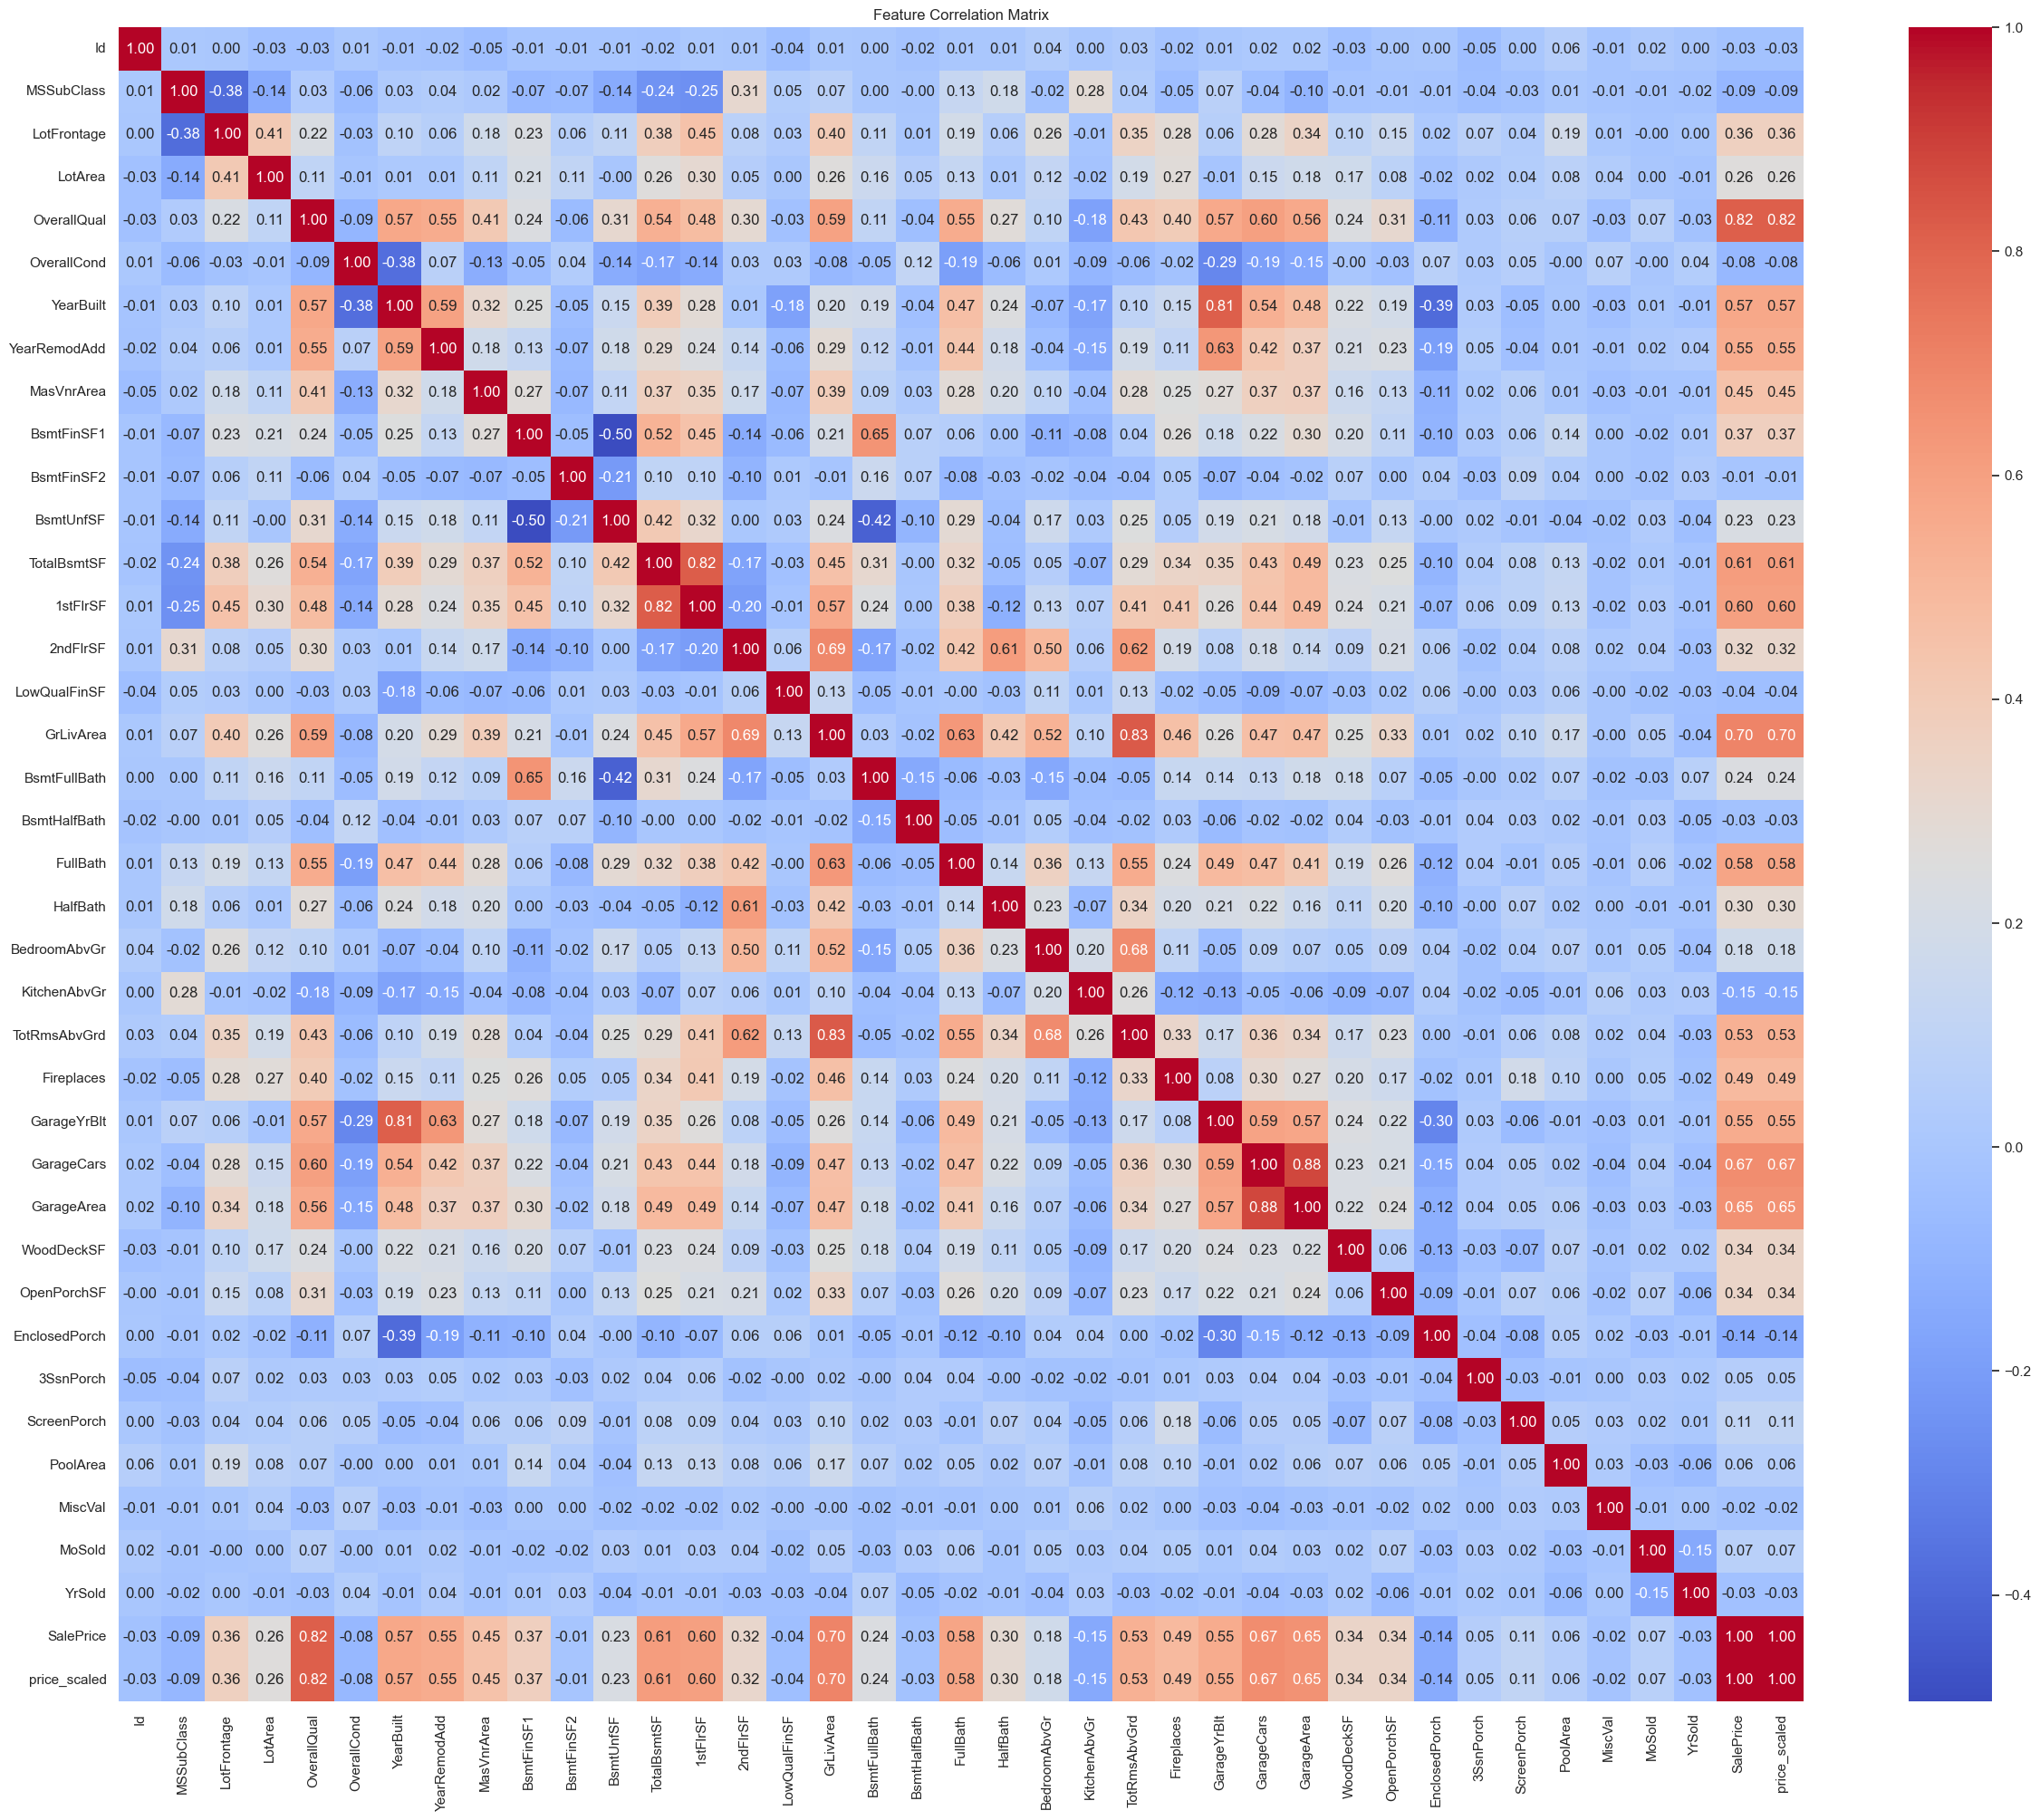

In [30]:
# 计算数值型特征的相关性矩阵
correlation_matrix = df.select_dtypes(include=np.number).corr()

# 使用热力图进行可视化
plt.figure(figsize=(30, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [25]:
# 初始化标准化器
scaler = StandardScaler()

# 对 price 列进行标准化
# fit_transform 需要一个二维数组，所以我们用 [[]] 来 reshape
df['price_scaled'] = scaler.fit_transform(df[['SalePrice']])

print("SalePrice 标准化后的前5行：\n", df[['SalePrice', 'price_scaled']].head())

SalePrice 标准化后的前5行：
    SalePrice  price_scaled
0   208500.0      0.463935
1   181500.0      0.062047
2   223500.0      0.687207
3   140000.0     -0.555671
4   250000.0      1.081653


In [26]:
# 将 price 分为4个等频的箱（每个箱包含约25%的数据）
df['price_binned_quantile'] = pd.qcut(df['SalePrice'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

print("price 离散化后的分布：\n", df['price_binned_quantile'].value_counts())

price 离散化后的分布：
 price_binned_quantile
Medium       367
High         366
Low          365
Very High    362
Name: count, dtype: int64


In [33]:
# 从相关性矩阵中提取与 'price' 相关的系数
price_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)

# 'price' 与自身的相关性是1，所以我们排除掉它，取接下来的三个
top_3_features = price_correlation[2:5] # 排除第一个（price本身）

print("与 'SalePrice' 相关性最高的三个特征是：\n", top_3_features)

与 'SalePrice' 相关性最高的三个特征是：
 OverallQual    0.816856
GrLivArea      0.699980
GarageCars     0.672293
Name: SalePrice, dtype: float64
